In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import plotly.figure_factory as ff
import nltk
import textblob
import seaborn as sns
from textblob import TextBlob
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
import plotly.express as px
import plotly as pl
import datetime

#for confusion matrix
import seaborn
from sklearn.metrics import confusion_matrix


nltk.download('wordnet')
print('Done')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Done


In [ ]:
train = pd.read_csv("train.csv")
train.text=train.text.astype(str)
train.selected_text=train.selected_text.astype(str)

In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [ ]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [ ]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

The number of words plot is really interesting ,the tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed

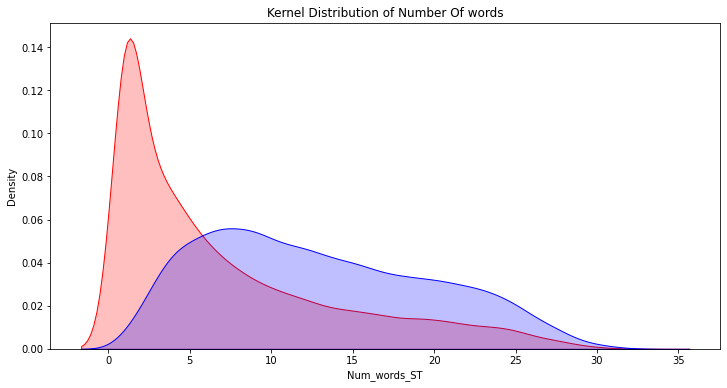

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

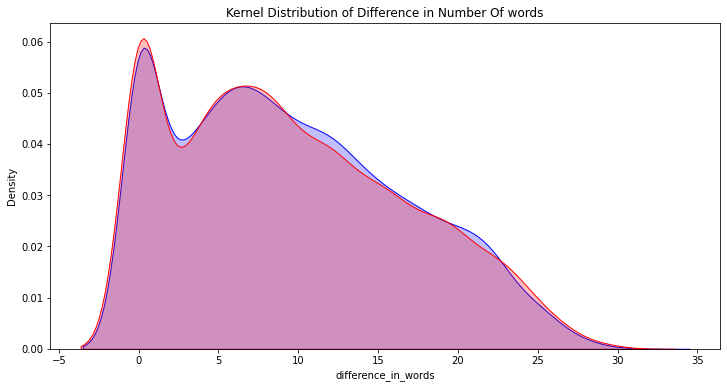

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

In [ ]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [ ]:
train.groupby('sentiment').nunique()

,textID,text,selected_text,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
sentiment,,,,,,,
negative,7781,7781,5861,197,30,32,31
neutral,11118,11118,11112,148,33,33,24
positive,8582,8582,5537,194,29,33,32


In [ ]:
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [ ]:
if (train["selected_text"].isnull().sum() > 0):
    train["selected_text"].fillna("No content", inplace = True)

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:20])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,',
 ' - some shameless plugging for the best Rangers forum on earth',
 'fun',
 'Soooo high',
 'Both of you',
 'Wow... u just became cooler.',
 'as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'like',
 'DANGERously',
 'lost',
 'test test from the LG enV2',
 'Uh oh, I am sunburned',
 '*sigh*',
 'sick',
 'onna',
 'Hes just not that into you']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:100])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler'], ['as', 'much', 'as', 'love', 'to', 'be', 'hopeful', 'reckon', 'the', 'chances', 'are', 'minimal', 'never', 'gonna', 'get', 'my', 'cake', 'and', 'stuff'], ['like'], ['dangerously'], ['lost'], ['test', 'test', 'from', 'the', 'lg', 'env'], ['uh', 'oh', 'am', 'sunburned'], ['sigh'], ['sick'], ['onna'], ['hes', 'just', 'not', 'that', 'into', 'you'], ['oh', 'marly', 'so', 'sorry', 'hope', 'you', 'find', 'her', 'soon'], ['interesting'], ['is', 'cleaning', 'the', 'house', 'for', 'her', 'family', 'who', 'is', 'comming', 'later', 'today'], ['gotta', 'restart', 'my', 'computer', 'thought', 'win', 'was', 'supposed', 'to', 'put', 'an', 'end', 'to', 'the', 'constant', 'rebootiness'], ['see', 'wat', 

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)
    
data = []
for i in range(len(data_words)):
    
    #for j in range(len(data_words[i])):
        #stemming
        #data_words[i][j] = lancaster.stem(data_words[i][j])
        #lemmatization
        #data_words[i][j] = data_words[i][j].format(data_words[i][j],wordnet_lemmatizer.lemmatize(data_words[i][j]))
    
    data.append(detokenize(data_words[i]))
print(data[:10])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of', 'some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow just became cooler']


In [ ]:
data = np.array(data)

In [ ]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [ ]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [ ]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(lstm_out, dropout = 0.2))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint1])

645/645 [==============================] - 296s 431ms/step - loss: 1.0216 - accuracy: 0.5519 - val_loss: 0.5709 - val_accuracy: 0.7555

Epoch 00001: val_accuracy improved from -inf to 0.75549, saving model to best_model1.hdf5


In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 20))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint2])

645/645 [==============================] - 280s 435ms/step - loss: 0.5136 - accuracy: 0.8042 - val_loss: 0.4831 - val_accuracy: 0.8093

Epoch 00001: val_accuracy improved from -inf to 0.80934, saving model to best_model2.hdf5


In [ ]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint3])

645/645 [==============================] - 15s 19ms/step - loss: 1.2745 - acc: 0.4664 - val_loss: 0.8963 - val_acc: 0.6073


In [ ]:
best_model = keras.models.load_model("./best_model2.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 25s - loss: 0.4831 - accuracy: 0.8093
Model accuracy:  0.8093436360359192


In [ ]:
predictions = best_model.predict(X_test)

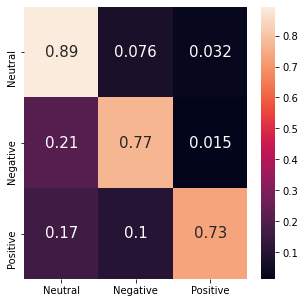

In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (5,5))
seaborn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
sequence = tokenizer.texts_to_sequences(['the trump administration failed to deliver on vaccine promises shocker covidiots coronavirus covidvaccine'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the great ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i feel the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

**EXTRA WORK**

In [ ]:
covidtweets = pd.read_csv('/content/vaccination_all_tweets.csv')
covidtweets.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVacci...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False


In [ ]:
print(covidtweets['id'].nunique())
print(covidtweets['user_name'].nunique())
print(covidtweets['user_location'].nunique())
print(covidtweets['user_description'].nunique())
print(covidtweets['user_created'].nunique())
print(covidtweets['user_friends'].nunique())
print(covidtweets['user_favourites'].nunique())
print(covidtweets['user_verified'].nunique())
print(covidtweets['date'].nunique())
print(covidtweets['text'].nunique())
print(covidtweets['hashtags'].nunique())
print(covidtweets['source'].nunique())
print(covidtweets['retweets'].nunique())
print(covidtweets['favorites'].nunique())
print(covidtweets['is_retweet'].nunique())

69718
37139
12761
35883
37789
6052
22440
2
68930
69621
23965
211
300
636
1


In [ ]:
covidtweets["text"].isnull().sum()

0

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = covidtweets["text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech ',
 'While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort weve ev… ',
 '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… ',
 'Facts are immutable, Senator, even when youre not ethically sturdy enough to acknowledge them. (1) You were born i… ',
 'Explain to me again why we need a vaccine #whereareallthesickpeople #PfizerBioNTech… ']

In [ ]:
data_words = list(sent_to_words(temp))
print(data_words[:10])

[['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', 'pfizerbiontech'], ['while', 'the', 'world', 'has', 'been', 'on', 'the', 'wrong', 'side', 'of', 'history', 'this', 'year', 'hopefully', 'the', 'biggest', 'vaccination', 'effort', 'weve', 'ev'], ['coronavirus', 'sputnikv', 'astrazeneca', 'pfizerbiontech', 'moderna', 'covid_', 'russian', 'vaccine', 'is', 'created', 'to', 'last', 'years'], ['facts', 'are', 'immutable', 'senator', 'even', 'when', 'youre', 'not', 'ethically', 'sturdy', 'enough', 'to', 'acknowledge', 'them', 'you', 'were', 'born'], ['explain', 'to', 'me', 'again', 'why', 'we', 'need', 'vaccine', 'pfizerbiontech'], ['does', 'anyone', 'have', 'any', 'useful', 'advice', 'guidance', 'for', 'whether', 'the', 'covid', 'vaccine', 'is', 'safe', 'whilst', 'breastfeeding'], ['it', 'is', 'bit', 'sad', 'to', 'claim', 'the', 'fame', 'for', 'success', 'of', 'vaccination', 'on', 'patriotic', 'competition', 'between', 'usa', 'canada', 'uk', 'and'], ['there'

In [ ]:
data = []
for i in range(len(data_words)):
    
    #for j in range(len(data_words[i])):
        #stemming
        #data_words[i][j] = lancaster.stem(data_words[i][j])
        #lemmatization
        #data_words[i][j] = data_words[i][j].format(data_words[i][j],wordnet_lemmatizer.lemmatize(data_words[i][j]))
        
    data.append(detokenize(data_words[i]))
print(data[:5])

['same folks said daikon paste could treat cytokine storm pfizerbiontech', 'while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev', 'coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_ russian vaccine is created to last years', 'facts are immutable senator even when youre not ethically sturdy enough to acknowledge them you were born', 'explain to me again why we need vaccine pfizerbiontech']


In [ ]:
data = np.array(data)

In [ ]:
covidtweets["sentiment"] = np.nan

In [ ]:
#covidtweets["sentiment"] = best_model.predict_classes(data)]
for i in range(len(temp)):
    sequence = tokenizer.texts_to_sequences([temp[i]])
    test = pad_sequences(sequence, maxlen=max_len)
    covidtweets["sentiment"][i] = sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]
    if (i % 461 == 0):
        percentage = i/len(temp) * 100
        formatted_percentage = "{:.0f}".format(percentage)
        print(formatted_percentage,"%")

0 %
1 %
1 %
2 %
3 %
3 %
4 %
5 %
5 %
6 %
7 %
7 %
8 %
9 %
9 %
10 %
11 %
11 %
12 %
13 %
13 %
14 %
15 %
15 %
16 %
17 %
17 %
18 %
19 %
19 %
20 %
20 %
21 %
22 %
22 %
23 %
24 %
24 %
25 %
26 %
26 %
27 %
28 %
28 %
29 %
30 %
30 %
31 %
32 %
32 %
33 %
34 %
34 %
35 %
36 %
36 %
37 %
38 %
38 %
39 %
40 %
40 %
41 %
42 %
42 %
43 %
44 %
44 %
45 %
46 %
46 %
47 %
48 %
48 %
49 %
50 %
50 %
51 %
52 %
52 %
53 %
54 %
54 %
55 %
56 %
56 %
57 %
58 %
58 %
59 %
60 %
60 %
61 %
61 %
62 %
63 %
63 %
64 %
65 %
65 %
66 %
67 %
67 %
68 %
69 %
69 %
70 %
71 %
71 %
72 %
73 %
73 %
74 %
75 %
75 %
76 %
77 %
77 %
78 %
79 %
79 %
80 %
81 %
81 %
82 %
83 %
83 %
84 %
85 %
85 %
86 %
87 %
87 %
88 %
89 %
89 %
90 %
91 %
91 %
92 %
93 %
93 %
94 %
95 %
95 %
96 %
97 %
97 %
98 %
99 %
99 %
100 %


In [ ]:
pd.set_option('display.max_colwidth', None)
covidtweets[["text", "sentiment"]].head(50)

,text,sentiment
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,Neutral
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",Neutral
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,Neutral
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",Neutral
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,Neutral
5,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,Neutral
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",Neutral
7,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,Neutral
8,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,Neutral
9,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",Neutral


  sentiment  tweets
0  Negative    4064
1   Neutral   62089
2  Positive    3565


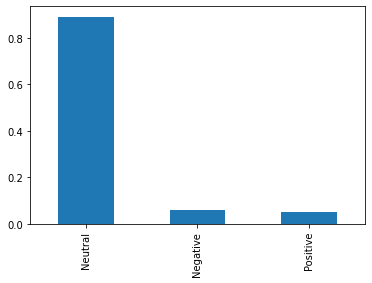

In [ ]:
# Plot sentiment value counts
covidtweets['sentiment'].value_counts(normalize=True).plot.bar();

timeline = covidtweets.groupby(['sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='sentiment', y="tweets", color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

In [ ]:
# Convert dates
covidtweets['date'] = pd.to_datetime(covidtweets['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = covidtweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"], category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

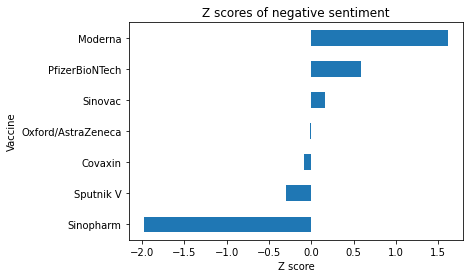

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(covidtweets, ['covaxin'], title='Covaxin')
sinovac = filtered_timeline(covidtweets, ['sinovac'], title='Sinovac')
sinopharm = filtered_timeline(covidtweets, ['sinopharm'], title='Sinopharm')
moderna = filtered_timeline(covidtweets, ['moderna'], title='Moderna')
sputnikv = filtered_timeline(covidtweets, ['sputnik'], title='Sputnik V')
oxford = filtered_timeline(covidtweets, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')
pfizer = filtered_timeline(covidtweets, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sputnik V': sputnikv, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['Negative', 'Neutral', 'Positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('Negative_zscore')['Negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

In [ ]:
# Function to filter the data to a single date and print tweets from users with the most followers
def date_filter(df, date):
    return df[df['date'].astype(str)==date].sort_values('user_followers', ascending=False)[['date' ,'text']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(moderna, ['2021-01-01', '2021-03-03'])

,date,text


,date,text
20114,2021-03-03,King Kullen has announced it received a limited supply of the first round of the #Moderna #COVID19 vaccines. \nhttps://t.co/UJWL4wgijZ
20183,2021-03-03,This is the definition of acute Stockholm Syndrome - he's been wildly ill after his experimental #Moderna mRNA gene… https://t.co/x1IAGkU5XA
20148,2021-03-03,"It's my second day after receiving my #Moderna #COVID19Vaccine too, and the incredible @GurdeepPandher captures the… https://t.co/Z6YHZv91Zh"
20202,2021-03-03,I'm happy to report that @JournalingIBD and myself received our 1st #Moderna vaccine on Monday and Tuesday this we… https://t.co/Ds5u68oTcn
20060,2021-03-03,#Moderna Suggests #Israel on its Radar for New #Vaccine Production Facility | United with Israel… https://t.co/hC9k6VfnA0
19234,2021-03-03,What a legend #Dolly #Moderna #COVID19 #vaccine @DollyParton https://t.co/wONZh9mF2q
19249,2021-03-03,I ❤ Dolly Parton.\nThanks for doing your civic and patriotic duty. #Moderna https://t.co/Gcsd3dP2yS
19292,2021-03-03,Dollllllyyy 😭😭😭\n#Moderna \n#COVID19Vaccine https://t.co/34dO14sGVT
19247,2021-03-03,"An example of how real artists should contribute in these difficult times.\n\nDolly made a big donation to #Moderna ,… https://t.co/aoIvjHudRQ"
20130,2021-03-03,"Got my first vaccination yesterday. My arm hurts a bit, but only when I use it. I'm also really drowsy. #Vaccine #Moderna"


In [ ]:
covidtweets[covidtweets['text'].str.lower().str.contains("pfizer")].head(15)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False,Neutral
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,Neutral
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,Neutral
8,1337850023531347969,Erin Despas,NaN,"Designing&selling on Teespring. Like 90s Disney tv movies, old school WWE. Dislikes Intolerance, hate, bigots and snakes https://t.co/fa5n4gEHgR",2009-10-30 17:53:54,887,1515,9639,False,2020-12-12,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,"['CovidVaccine', 'covid19', 'PfizerBioNTech', 'Moderna']",Twitter Web App,2,1,False,Neutral
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (freelance) for some companies that need analysis for their products in Int. Markets \n- Instagram : tamervisits -",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,Neutral
11,1337840331522453507,VoiceM,NaN,campaigner & optimistic realist,2020-08-31 10:38:21,2,25,20,False,2020-12-12,@cnnbrk #COVID19 #CovidVaccine #vaccine #Corona #PfizerBioNTech #bbcnews #NYTimes #BBCNews Best wishes to the US… https://t.co/9xWmfU3LZj,"['COVID19', 'CovidVaccine', 'vaccine', 'Corona', 'PfizerBioNTech', 'bbcnews', 'NYTimes', 'BBCNews']",Twitter Web App,0,0,False,Positive
13,1337809196453081088,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emerging Infections, & Health Policy MD| U.S. Congress COVID-19 expert witness x 2 | ELBI 2020 @JHSPH_CHS",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12,For all the women and healthcare providers who have been asking about the safety of the #PfizerBioNTech… https://t.co/ow0Pglkwte,['PfizerBioNTech'],Twitter for iPhone,48,82,False,Neutral
16,1337789191598575616,STOPCOMMONPASS.ORG,Global,"'Trust' is not carte-blanche for erosion of our liberty, privacy, & the pursuit of global control.",2020-10-25 20:33:33,406,176,479,False,2020-12-12,UPDATED: #YellowFever &amp; #COVID19 #ImmunityPassports - Part Two\n\n#SARSCoV2 #PfizerBioNtech #Britain #December… https://t.co/qKT7Rst9aW,"['YellowFever', 'COVID19', 'ImmunityPassports', 'SARSCoV2', 'PfizerBioNtech', 'Britain', 'December']",Twitter Web App,2,2,False,Neutral
17,1337783770070409218,ILKHA,Türkiye,Official Twitter account of Ilke News Agency /,2015-05-22 08:31:12,4056,6,3,True,2020-12-12,"Coronavirus: Iran reports 8,201 new cases, 221 deaths in the last 24 hours #Iran #coronavirus #PfizerBioNTech… https://t.co/mwDNAdmb7F","['Iran', 'coronavirus', 'PfizerBioNTech']",TweetDeck,3,5,False,Neutral
18,1337781178665816064,Braderz73🌹#GTTO 🇪🇺 🇬🇧,"Bristol, UK","One of those lefty types, I believe in a fai

In [ ]:
!pip install wordninja pyspellchecker
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")
import math
import random

     |████████████████████████████████| 542kB 4.0MB/s 
     |████████████████████████████████| 2.7MB 25.1MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541554 sha256=e488d6c9b34a62f4aa9ed7e8cb5256c08b552fcbc1f5908289cee74d6f6fb43a
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# FUNCTIONS REQUIRED

def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")
    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud



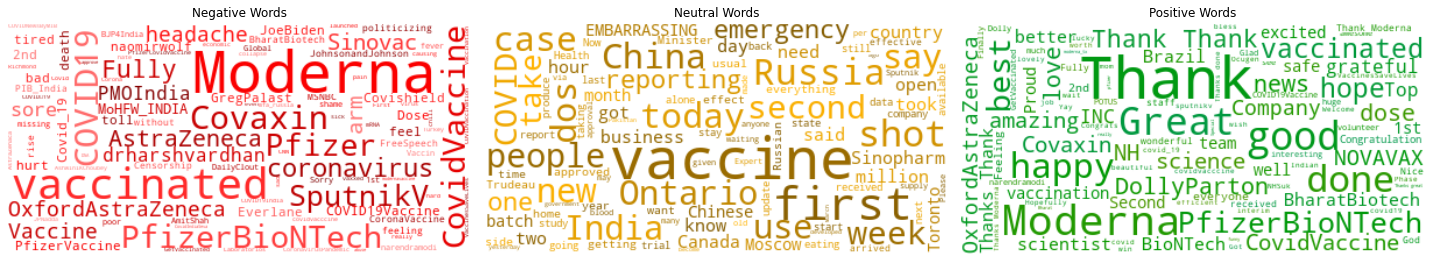

In [ ]:
covidtweets['words'] = covidtweets.text.apply(lambda x:re.findall(r'\w+', x ))

def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='Negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='Positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='Neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
get_smart_clouds(covidtweets)